# Dogs vs Cats With Transfer Learning Using Keras

In [1]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.1
Is using GPU? False


In [2]:
pets.download_and_extract('data','.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [3]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot,count_train=pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot,count_test=pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print("Training examples: ",count_train)
print("Test examples: ",count_test)

Training examples:  3680
Test examples:  3669


In [4]:
image_dir='data/images/'
imgpath=''
def get_random_batch(annot,batch_size=4):
    all_keys=list(annot.keys())
    n=len(all_keys)
    
    indices=np.random.choice(range(n),batch_size)
    
    x=np.zeros((batch_size,128,128,3))
    y=np.zeros((batch_size,1))
    images=[]
    
    for i,index in enumerate(indices):
        imgpath=os.path.join(image_dir,all_keys[index])
        image=tf.keras.preprocessing.image.load_img(imgpath,target_size=(128,128))
        arr=tf.keras.preprocessing.image.img_to_array(image)
        arr=tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr=np.expand_dims(arr,axis=0)
        x[i]=arr
        y[i]=class_to_index[annot[all_keys[index]]]
        images.append(image)
        
    return x,y,images

Displaying first 8 examples..


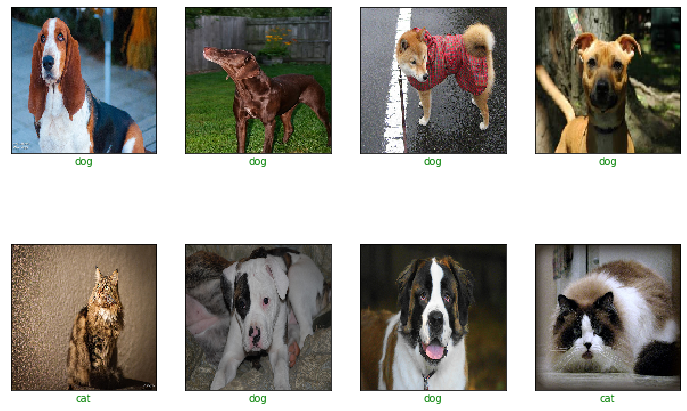

In [5]:
x,y,images=get_random_batch(train_annot,batch_size=8)
pets.display_examples(x,y,y,images,index_to_class).show()

In [6]:
mnet=tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,pooling='avg',
    weights='imagenet',input_shape=(128,128,3)
)
mnet.summary()


Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [7]:
model=tf.keras.models.Sequential([
    mnet,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.layers[0].trainable=False
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
def data_generator(batch_size,annot):
    while True:
        x,y,_=get_random_batch(annot,batch_size)
        yield(x,y)

In [9]:
batch_size=32
steps_per_epoch=int(count_train/batch_size)
validation_steps=int(count_test/batch_size)

print("Training steps: ",steps_per_epoch)
print("Validation Steps: ",validation_steps)

Training steps:  115
Validation Steps:  114


In [10]:
%%time

history=model.fit_generator(
    data_generator(batch_size,train_annot),
    validation_data=data_generator(batch_size,test_annot),
    steps_per_epoch=steps_per_epoch,
    epochs=1,
    validation_steps=validation_steps
)

115/115 [==============================] - 911s 8s/step - loss: 0.4746 - accuracy: 0.7810 - val_loss: 0.1692 - val_accuracy: 0.9512
Wall time: 15min 10s


Displaying first 8 examples..


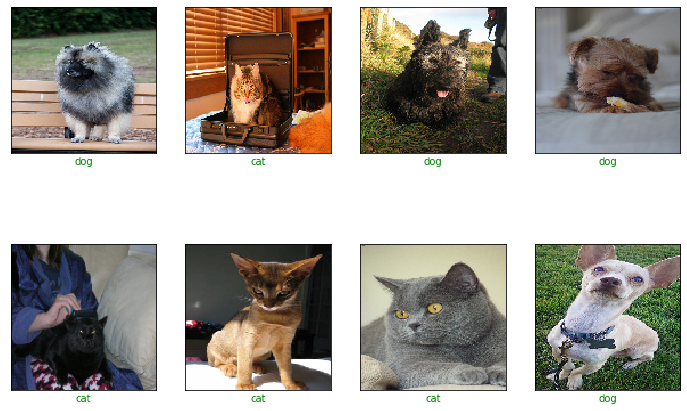

In [13]:
x,y,images=get_random_batch(test_annot,batch_size=8)
preds=model.predict(x)
pets.display_examples(x,y,preds,images,index_to_class).show()